Future needs for project:
- Input try/exception into the API call to account for errors (limit exceeded, etc.)
- random date generator to get weather data for dates that weren't associated with fires
- rolling totals/avg as predictors for the following - precipitation sum (maybe 30 day rolling, percentage of days it rained multiplied by total amount), average relative humidity (weekly lag?), and adding in evapotranspiration. 

In [22]:
# imports and installs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

%matplotlib inline

import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import requests
from datetime import datetime
from datetime import timedelta

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## Functions

In [ ]:
# Function for generating random dates not present in original fire dataset.
# To be used for weather data not assigned fires.
def rand_date(input_df, record_length=5000):
    minimum_date = input_df["date"].min()
    maximum_date = input_df["date"].max()

    listed_date = [minimum_date]
    new_dates = []

    while minimum_date != maximum_date:
        minimum_date += timedelta(days=1)
        if minimum_date in input_df["date"]:
            pass
        else:
            listed_date.append(minimum_date)

    for i in range(record_length):
        rand_num = np.random.randint(0, len(listed_date))
        curr_date = listed_date[rand_num]
        new_dates.append(curr_date)

    return pd.Series(new_dates)

## Gathering Data - Historical and API

In [47]:
# Reading in random samples from historical data of a given length.
record_length = 300
directory = "/Users/coleparker/Documents/Udemy/Personal Challenges/Fire_Prediction/"
file_name = "Fire_Occurrence_Data_2000_2022.csv"

df_fire_full = pd.read_csv(directory + file_name)
df_fire_cleaned = df_fire_full.drop(
    [
        "Serial",
        "FireCategory",
        "Area",
        "DistrictName",
        "UnitName",
        "FullFireNumber",
        "Cause_Comments",
        "LatLongDD",
        "FO_LandOwnType",
        "Twn",
        "Rng",
        "Sec",
        "Subdiv",
        "LandmarkLocation",
        "County",
        "RegUseZone",
        "RegUseRestriction",
        "Industrial_Restriction",
        "DistrictCode",
        "UnitCode",
        "DistFireNumber",
    ],
    axis=1,
)
df_fire_cleaned.sort_values(["ReportDateTime"], inplace=True, ascending=False)
df_fire_cleaned = df_fire_cleaned.sample(n=record_length)

# Dropping any null rows
df_fire_cleaned = df_fire_cleaned.dropna()

# Converting datetime columns to appropriate datatype
df_fire_cleaned["Ign_DateTime"] = pd.to_datetime(
    df_fire_cleaned["Ign_DateTime"], format="%m/%d/%Y %I:%M:%S %p"
)
df_fire_cleaned["Control_DateTime"] = pd.to_datetime(
    df_fire_cleaned["Control_DateTime"], format="%m/%d/%Y %I:%M:%S %p"
)

# Invalid data where the controlled datetime occured before the ignite datetime. 
df_fire_cleaned = df_fire_cleaned.drop(
    df_fire_cleaned.index[
        df_fire_cleaned["Control_DateTime"] < df_fire_cleaned["Ign_DateTime"]
    ].tolist()
)

### API Call

The below cell is retrieving weather data associated with the historical fire data and also pulling weather data for dates which are NOT present in the historical fire data. 

In [49]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession(".cache", expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=5)
openmeteo = openmeteo_requests.Client(session=retry_session)

hourly_dataframe_agg = pd.DataFrame()
daily_dataframe_agg = pd.DataFrame()

# try:
for point in tqdm(range(len(df_fire_cleaned))):
    lat_current = df_fire_cleaned["Lat_DD"].iloc[point]
    long_current = df_fire_cleaned["Long_DD"].iloc[point]

    # Make sure all required weather variables are listed here
    # The order of variables in hourly or daily is important to assign them correctly below
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat_current,
        "longitude": long_current,
        "start_date": datetime.strftime(
            df_fire_cleaned["Ign_DateTime"].iloc[point].date(), "%Y-%m-%d"
        ),
        "end_date": datetime.strftime(
            df_fire_cleaned["Control_DateTime"].iloc[point].date(), "%Y-%m-%d"
        ),
        "hourly": ["soil_moisture_0_to_7cm", "surface_pressure"],
        "daily": ["wind_speed_10m_max", "et0_fao_evapotranspiration"],
        "temperature_unit": "fahrenheit",
        "wind_speed_unit": "mph",
        "precipitation_unit": "inch",
        "timezone": "America/Los_Angeles",
    }
    responses = openmeteo.weather_api(url, params=params)

    response = responses[0]

    # Process hourly data. The order of variables needs to be the same as requested.
    hourly = response.Hourly()
    hourly_soil_moisture_0_to_7cm = hourly.Variables(0).ValuesAsNumpy()
    hourly_surface_pressure = hourly.Variables(1).ValuesAsNumpy()

    hourly_data = {
        "date": pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left",
        )
    }
    hourly_data["soil_moisture_0_to_7cm"] = hourly_soil_moisture_0_to_7cm
    hourly_data["surface_pressure"] = hourly_surface_pressure

    hourly_dataframe = pd.DataFrame(data=hourly_data)
    df_fire_cleaned_repeat_hour = pd.DataFrame(
        np.tile(df_fire_cleaned.iloc[point].values, (len(hourly_dataframe), 1)),
        columns=df_fire_cleaned.columns,
    )
    hourly_dataframe = pd.concat([hourly_dataframe, df_fire_cleaned_repeat_hour], axis=1)
    hourly_dataframe_agg = pd.concat(
        [hourly_dataframe_agg, hourly_dataframe], ignore_index=True, axis=0
    )

    # Process daily data. The order of variables needs to be the same as requested.
    daily = response.Daily()
    daily_wind_speed_10m_max = daily.Variables(0).ValuesAsNumpy()
    daily_et0_fao_evapotranspiration = daily.Variables(1).ValuesAsNumpy()

    daily_data = {
        "date": pd.date_range(
            start=pd.to_datetime(daily.Time(), unit="s", utc=True),
            end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=daily.Interval()),
            inclusive="left",
        )
    }
    daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
    daily_data["et0_fao_evapotranspiration"] = daily_et0_fao_evapotranspiration

    daily_dataframe = pd.DataFrame(data=daily_data)
    df_fire_cleaned_repeat_day = pd.DataFrame(
        np.tile(df_fire_cleaned.iloc[point].values, (len(daily_dataframe), 1)),
        columns=df_fire_cleaned.columns,
    )
    daily_dataframe = pd.concat([daily_dataframe, df_fire_cleaned_repeat_day], axis=1)
    daily_dataframe_agg = pd.concat(
        [daily_dataframe_agg, daily_dataframe], ignore_index=True, axis=0
    )
# except:
# print("API limit reached - retry later")

generated_dates = rand_date(daily_dataframe_agg, 5000)
extra_hourly_dataframe_agg = pd.DataFrame()
extra_daily_dataframe_agg = pd.DataFrame()

# try:
for point in tqdm(range(len(generated_dates))):
    lat_long_modulo = point % len(df_fire_cleaned)
    lat_current = df_fire_cleaned["Lat_DD"].iloc[lat_long_modulo]
    long_current = df_fire_cleaned["Long_DD"].iloc[lat_long_modulo]

    # Make sure all required weather variables are listed here
    # The order of variables in hourly or daily is important to assign them correctly below
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat_current,
        "longitude": long_current,
        "start_date": datetime.strftime(generated_dates[point].date(), "%Y-%m-%d"),
        "end_date": datetime.strftime(generated_dates[point].date(), "%Y-%m-%d"),
        "hourly": ["soil_moisture_0_to_7cm", "surface_pressure"],
        "daily": ["wind_speed_10m_max", "et0_fao_evapotranspiration"],
        "temperature_unit": "fahrenheit",
        "wind_speed_unit": "mph",
        "precipitation_unit": "inch",
        "timezone": "America/Los_Angeles",
    }
    responses = openmeteo.weather_api(url, params=params)

    response = responses[0]

    # Process hourly data. The order of variables needs to be the same as requested.
    hourly = response.Hourly()
    hourly_soil_moisture_0_to_7cm = hourly.Variables(0).ValuesAsNumpy()
    hourly_surface_pressure = hourly.Variables(1).ValuesAsNumpy()

    hourly_data = {
        "date": pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left",
        )
    }
    hourly_data["soil_moisture_0_to_7cm"] = hourly_soil_moisture_0_to_7cm
    hourly_data["surface_pressure"] = hourly_surface_pressure

    extra_hourly_dataframe = pd.DataFrame(data=hourly_data)
    extra_df_fire_cleaned_repeat_hour = pd.DataFrame(
        np.tile(
            df_fire_cleaned.iloc[lat_long_modulo].values, (len(extra_hourly_dataframe), 1)
        ),
        columns=df_fire_cleaned.columns,
    )
    extra_hourly_dataframe = pd.concat(
        [extra_hourly_dataframe, extra_df_fire_cleaned_repeat_hour], axis=1
    )
    extra_hourly_dataframe_agg = pd.concat(
        [extra_hourly_dataframe_agg, extra_hourly_dataframe], ignore_index=True, axis=0
    )

    # Process daily data. The order of variables needs to be the same as requested.
    daily = response.Daily()
    daily_wind_speed_10m_max = daily.Variables(0).ValuesAsNumpy()
    daily_et0_fao_evapotranspiration = daily.Variables(1).ValuesAsNumpy()

    daily_data = {
        "date": pd.date_range(
            start=pd.to_datetime(daily.Time(), unit="s", utc=True),
            end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=daily.Interval()),
            inclusive="left",
        )
    }
    daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
    daily_data["et0_fao_evapotranspiration"] = daily_et0_fao_evapotranspiration

    extra_daily_dataframe = pd.DataFrame(data=daily_data)
    extra_df_fire_cleaned_repeat_day = pd.DataFrame(
        np.tile(
            df_fire_cleaned.iloc[lat_long_modulo].values, (len(extra_daily_dataframe), 1)
        ),
        columns=df_fire_cleaned.columns,
    )
    extra_daily_dataframe = pd.concat(
        [extra_daily_dataframe, extra_df_fire_cleaned_repeat_day], axis=1
    )
    extra_daily_dataframe_agg = pd.concat(
        [extra_daily_dataframe_agg, extra_daily_dataframe], ignore_index=True, axis=0
    )
# except:
# print("API limit reached - retry later")

hourly_dataframe_agg = pd.concat(
    [hourly_dataframe_agg, extra_hourly_dataframe_agg], ignore_index=True, axis=0
)
daily_dataframe_agg = pd.concat(
    [daily_dataframe_agg, extra_daily_dataframe_agg], ignore_index=True, axis=0
)

  0%|          | 0/297 [00:01<?, ?it/s]


OpenMeteoRequestsError: {'reason': 'Daily API request limit exceeded. Please try again tomorrow.', 'error': True}

## Conversions and Cleanup

In [38]:
# Replacing size class with numeric values
size_class_dict = {"A": 1, "B": 1, "C": 1, "D": 1, "E": 1, "F": 1}
daily_dataframe_agg["Size_class"] = daily_dataframe_agg["Size_class"].map(
    size_class_dict
)

# Converting to numeric
daily_dataframe_agg["EstTotalAcres"] = pd.to_numeric(
    daily_dataframe_agg["EstTotalAcres"]
)

# Converting to UTC datetime
daily_dataframe_agg["date"] = daily_dataframe_agg["date"].dt.tz_convert("UTC")
daily_dataframe_agg["Ign_DateTime"] = daily_dataframe_agg["Ign_DateTime"].dt.tz_localize("UTC")
daily_dataframe_agg["ReportDateTime"] = pd.to_datetime(daily_dataframe_agg["ReportDateTime"]).dt.tz_localize("UTC")
daily_dataframe_agg["Discover_DateTime"] = pd.to_datetime(daily_dataframe_agg["Discover_DateTime"]).dt.tz_localize("UTC")
daily_dataframe_agg["Control_DateTime"] = daily_dataframe_agg["Control_DateTime"].dt.tz_localize("UTC")
daily_dataframe_agg["CreationDate"] = pd.to_datetime(daily_dataframe_agg["CreationDate"]).dt.tz_localize("UTC")
daily_dataframe_agg["ModifiedDate"] = pd.to_datetime(daily_dataframe_agg["ModifiedDate"]).dt.tz_localize("UTC")
hourly_dataframe_agg["date"] = hourly_dataframe_agg["date"].dt.tz_convert("UTC")
hourly_dataframe_agg["Ign_DateTime"] = hourly_dataframe_agg["Ign_DateTime"].dt.tz_localize("UTC")
hourly_dataframe_agg["ReportDateTime"] = pd.to_datetime(hourly_dataframe_agg["ReportDateTime"]).dt.tz_localize("UTC")
hourly_dataframe_agg["Discover_DateTime"] = pd.to_datetime(hourly_dataframe_agg["Discover_DateTime"]).dt.tz_localize("UTC")
hourly_dataframe_agg["Control_DateTime"] = hourly_dataframe_agg["Control_DateTime"].dt.tz_localize("UTC")
hourly_dataframe_agg["CreationDate"] = pd.to_datetime(hourly_dataframe_agg["CreationDate"]).dt.tz_localize("UTC")
hourly_dataframe_agg["ModifiedDate"] = pd.to_datetime(hourly_dataframe_agg["ModifiedDate"]).dt.tz_localize("UTC")

/var/folders/vr/_3gy4clj6932_zwdwb7jml_m0000gn/T/ipykernel_42676/1302385989.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  daily_dataframe_agg['CreationDate'] = pd.to_datetime(daily_dataframe_agg['CreationDate']).dt.tz_localize('UTC')
/var/folders/vr/_3gy4clj6932_zwdwb7jml_m0000gn/T/ipykernel_42676/1302385989.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  daily_dataframe_agg['ModifiedDate'] = pd.to_datetime(daily_dataframe_agg['ModifiedDate']).dt.tz_localize('UTC')
/var/folders/vr/_3gy4clj6932_zwdwb7jml_m0000gn/T/ipykernel_42676/1302385989.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expect

In [39]:
# Aggregating the hourly data to the daily level with mean so it can
# be combined with the daily dataframe. 
daily_addhourly_dataframe_agg = hourly_dataframe_agg.groupby(
    [
        "FireName",
        "Size_class",
        "EstTotalAcres",
        "Protected_Acres",
        "HumanOrLightning",
        "CauseBy",
        "GeneralCause",
        "SpecificCause",
        "Lat_DD",
        "Long_DD",
        "Ign_DateTime",
        "ReportDateTime",
        "Discover_DateTime",
        "Control_DateTime",
        "CreationDate",
        "ModifiedDate",
        "date",
        "FireYear",
    ],
    as_index=False,
).mean()

daily_addhourly_dataframe_agg.drop(
    [
        "Size_class",
        "EstTotalAcres",
        "Protected_Acres",
        "HumanOrLightning",
        "CauseBy",
        "GeneralCause",
        "SpecificCause",
        "Lat_DD",
        "Long_DD",
        "Ign_DateTime",
        "ReportDateTime",
        "Discover_DateTime",
        "Control_DateTime",
        "CreationDate",
        "ModifiedDate",
        "FireYear",
    ],
    axis=1,
    inplace=True,
)

In [40]:
# Combination of aggregared hourly and daily dataframes. 
daily_dataframe_merged = daily_dataframe_agg.merge(
    daily_addhourly_dataframe_agg, on=["FireName", "date"], how="left"
)

# If the date column is less than the Ign_DateTime column, this means it is
# not assocaited with a fire, so we fill all fire-related columns with nan. 
daily_dataframe_merged.loc[
    daily_dataframe_merged["date"].dt.date < daily_dataframe_merged["Ign_DateTime"].dt.date,
    [
        "FireYear",
        "FireName",
        "Size_class",
        "EstTotalAcres",
        "Protected_Acres",
        "HumanOrLightning",
        "CauseBy",
        "GeneralCause",
        "SpecificCause",
        "Ign_DateTime",
        "ReportDateTime",
        "Discover_DateTime",
        "Control_DateTime",
        "CreationDate",
        "ModifiedDate",
    ],
] = np.nan

daily_dataframe_merged.drop(
    [
        "Lat_DD",
        "Long_DD",
        "FireYear",
        "FireName",
        "EstTotalAcres",
        "Protected_Acres",
        "HumanOrLightning",
        "CauseBy",
        "GeneralCause",
        "SpecificCause",
        "Ign_DateTime",
        "ReportDateTime",
        "Discover_DateTime",
        "Control_DateTime",
        "CreationDate",
        "ModifiedDate",
    ],
    axis=1,
    inplace=True,
)

# Replace nan class with 0, indicating no fire occured. 
daily_dataframe_merged["Size_class"] = daily_dataframe_merged["Size_class"].fillna(value=0.0)

## Visualizing Features

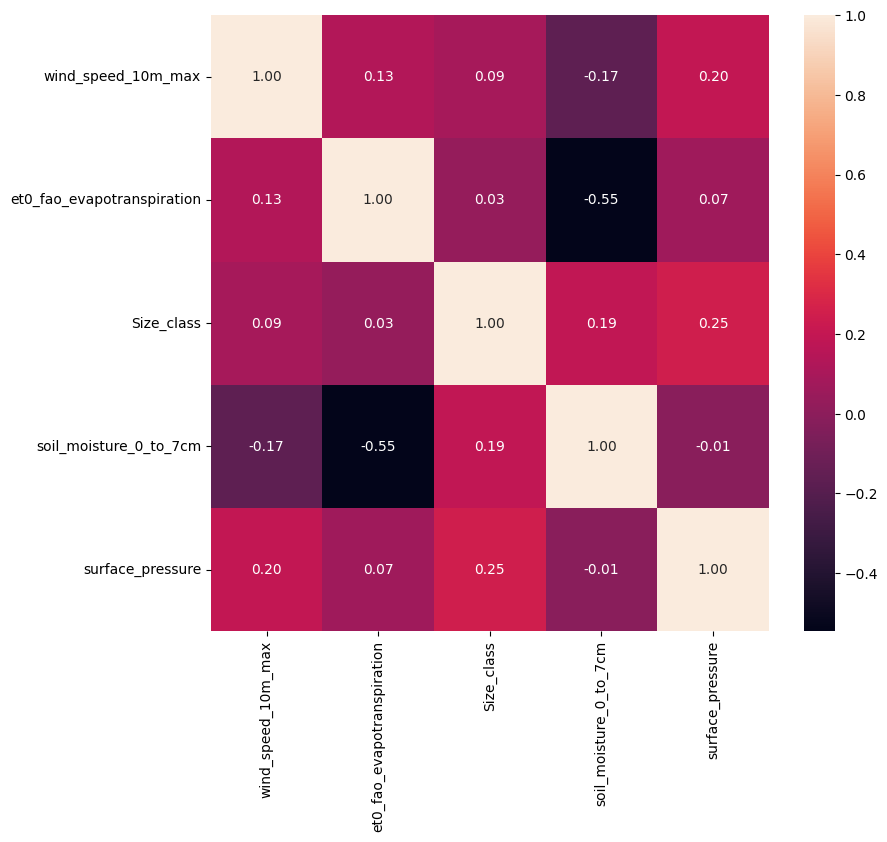

In [41]:
# Visualization to compare size class correlations with numeric variables
plt.figure(figsize=(9, 8))
sns.heatmap(daily_dataframe_merged.corr(numeric_only=True), annot=True, fmt=".2f")
plt.show()

## Training & Model Evaluation

In [42]:
# Initializing and training an ensemble model for classification. Precision & 
# Recall used to identify performance instead of pure accuracy. 

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

pd_X = daily_dataframe_merged.drop(["Size_class", "date"], axis=1)
pd_y = daily_dataframe_merged["Size_class"]
X_train, X_test, y_train, y_test = train_test_split(pd_X, pd_y, test_size=0.2)

# model = RandomForestClassifier(n_estimators = 100, criterion = 'gini', class_weight = 'balanced')
# model = LogisticRegression(class_weight = 'balanced')
model = XGBClassifier(max_depth=3, objective="binary:logistic")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(model.score(X_test, y_test))

              precision    recall  f1-score   support

         0.0       1.00      0.50      0.67         4
         1.0       0.99      1.00      1.00       282

    accuracy                           0.99       286
   macro avg       1.00      0.75      0.83       286
weighted avg       0.99      0.99      0.99       286

0.993006993006993


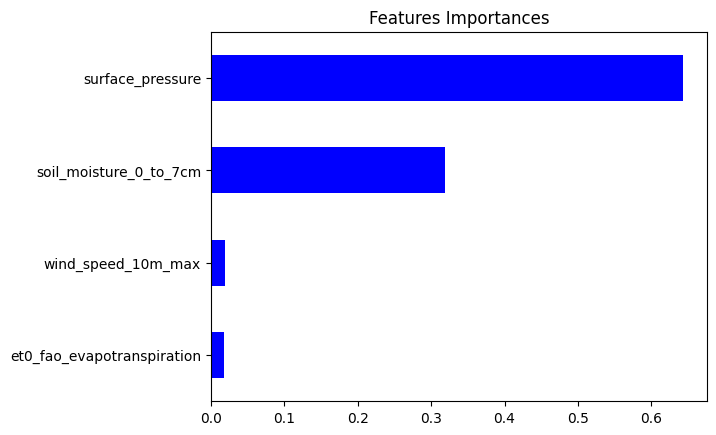

In [43]:
# Create a pd.Series of features importances
importances = pd.Series(data=model.feature_importances_, index=X_train.columns)
# Sort importances
importances_sorted = importances.sort_values()
# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind="barh", color="blue")
plt.title("Features Importances")
plt.show()

In [54]:
len(daily_dataframe_agg["date"].unique())

9761